In [58]:
!pip install sklearn
!pip install scikit-learn
!pip install matplotlib
!pip install numpy
!pip install cv2
!pip3 install opencv-python


  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-pypi-packag

ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2


In [59]:
!pip install numpy opencv-python matplotlib scikit-learn albumentations tqdm

In [60]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import albumentations as A
from collections import Counter
import random
from tqdm import tqdm

# Base directory containing all class folders
BASE_DIR = './caltech-101'  # Adjust this path as needed
OUTPUT_DIR = './processed_dataset'  # Directory for processed images
TARGET_SIZE = (224, 224)  # Standard size for all images

In [61]:

def load_and_preprocess_image(img_path):
    """
    Load and preprocess image, converting grayscale to RGB if needed
    """
    # Read image
    img = cv2.imread(img_path)
    
    if img is None:
        return None
        
    # Convert BGR to RGB
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        # If grayscale, convert to RGB by stacking channels
        img = np.stack((img,)*3, axis=-1)
    
    # Resize image
    img_resized = cv2.resize(img, TARGET_SIZE)
    
    return img_resized

def create_processed_dataset():
    """
    Process all images to same size and convert to RGB if grayscale
    """
    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)
    
    processed_images = []
    labels = []
    class_names = sorted(os.listdir(BASE_DIR))
    
    for class_idx, class_name in enumerate(tqdm(class_names)):
        # Create class directory in output folder
        class_output_dir = os.path.join(OUTPUT_DIR, class_name)
        if not os.path.exists(class_output_dir):
            os.makedirs(class_output_dir)
            
        class_dir = os.path.join(BASE_DIR, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            
            # Load and preprocess image
            img_processed = load_and_preprocess_image(img_path)
            
            if img_processed is not None:
                # Generate new filename
                new_filename = os.path.splitext(img_name)[0] + '.png'
                output_path = os.path.join(class_output_dir, new_filename)
                
                # Save as PNG
                plt.imsave(output_path, img_processed)
                
                processed_images.append(img_processed)
                labels.append(class_idx)
    
    return np.array(processed_images), np.array(labels), class_names

In [62]:
def load_dataset():
    """
    Load processed images and labels
    """
    if not os.path.exists(OUTPUT_DIR):
        print("Processing and saving images...")
        return create_processed_dataset()
    
    print("Loading processed images...")
    images = []
    labels = []
    class_names = sorted(os.listdir(OUTPUT_DIR))
    
    for class_idx, class_name in enumerate(tqdm(class_names)):
        class_dir = os.path.join(OUTPUT_DIR, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = plt.imread(img_path)
            images.append(img)
            labels.append(class_idx)
    
    return np.array(images), np.array(labels), class_names

def split_dataset(images, labels):
    """
    Split dataset into train, validation, and test sets (80:10:10)
    using stratified sampling
    """
    # First split: 80% train, 20% temp
    X_train, X_temp, y_train, y_temp = train_test_split(
        images, labels, test_size=0.2, stratify=labels, random_state=42
    )
    
    # Second split: Split temp into validation and test (50% each, resulting in 10% of original data)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
    )
    
    return X_train, X_val, X_test, y_train, y_val, y_test


In [63]:
def plot_random_images(images, labels, class_names, num_images=10):
    """
    Plot random images from the dataset with their class labels
    """
    indices = np.random.choice(len(images), num_images, replace=False)
    plt.figure(figsize=(20, 10))
    
    for i, idx in enumerate(indices):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[idx])
        plt.title(class_names[labels[idx]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def plot_class_distribution(labels, class_names):
    """
    Plot class distribution bar plot and print imbalance solutions
    """
    class_counts = Counter(labels)
    plt.figure(figsize=(15, 5))
    plt.bar(range(len(class_names)), [class_counts[i] for i in range(len(class_names))])
    plt.xticks(range(len(class_names)), class_names, rotation=90)
    plt.title('Class Distribution')
    plt.xlabel('Classes')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()
    
    # Print class imbalance solutions
    print("\nTechniques to handle class imbalance:")
    print("1. Oversampling minority classes using techniques like SMOTE")
    print("2. Undersampling majority classes")
    print("3. Class weights in model training")
    print("4. Data augmentation for minority classes")
    print("5. Mixed sampling approaches")

def plot_rgb_histograms(images, num_images=5):
    """
    Plot RGB or grayscale histograms for random images
    Handles both RGB and grayscale images appropriately
    """
    indices = np.random.choice(len(images), num_images, replace=False)
    
    for idx in indices:
        img = images[idx]
        
        # Check if image is grayscale or RGB
        if len(img.shape) == 2:  # Grayscale image
            plt.figure(figsize=(5, 5))
            histogram = cv2.calcHist([img.astype(np.uint8)], [0], None, [256], [0, 256])
            plt.plot(histogram, color='gray')
            plt.title(f'Grayscale Histogram\nImage Shape: {img.shape}')
            plt.xlabel('Pixel Value')
            plt.ylabel('Frequency')
            plt.xlim([0, 256])
            
        else:  # RGB image
            colors = ('r', 'g', 'b')
            plt.figure(figsize=(15, 5))
            
            for i, color in enumerate(colors):
                plt.subplot(1, 3, i + 1)
                histogram = cv2.calcHist([img.astype(np.uint8)], [i], None, [256], [0, 256])
                plt.plot(histogram, color=color)
                plt.title(f'{color.upper()} Channel\nImage Shape: {img.shape}')
                plt.xlabel('Pixel Value')
                plt.ylabel('Frequency')
                plt.xlim([0, 256])
        
        plt.tight_layout()
        plt.show()

In [64]:
def apply_geometric_augmentations(images, num_images=5):
    """
    Apply geometric augmentations to random images using correct Albumentations transforms
    """
    indices = np.random.choice(len(images), num_images, replace=False)
    
    # Define geometric augmentations with correct transform names
    geometric_transform = A.Compose([
        A.RandomRotate90(p=0.7),
        A.HorizontalFlip(p=0.7),  # Changed from Flip to HorizontalFlip
        A.ShiftScaleRotate(p=0.7)
    ])
    
    for idx in indices:
        img = images[idx]
        augmented = geometric_transform(image=img.astype(np.uint8))['image']
        
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title('Original')
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(augmented)
        plt.title('Geometrically Augmented')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

In [65]:
def apply_color_augmentations(images, num_images=5):
    """
    Apply color augmentations to random images using correct Albumentations transforms
    """
    indices = np.random.choice(len(images), num_images, replace=False)
    
    # Define color augmentations with correct transform names
    color_transform = A.Compose([
        A.RandomBrightnessContrast(p=0.7),
        A.HueSaturationValue(p=0.7),
        A.CLAHE(p=0.7),
        A.Blur(blur_limit=7, p=0.5),
        A.GaussNoise(p=0.5),
        A.Sharpen(p=0.5),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.7),
        A.Emboss(p=0.5),
        A.RandomGamma(p=0.5),
        A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, p=0.7)
    ])
    
    for idx in indices:
        img = images[idx]
        augmented = color_transform(image=img.astype(np.uint8))['image']
        
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title('Original')
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(augmented)
        plt.title('Color Augmented')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

Loading dataset...
Processing and saving images...


100%|██████████| 102/102 [03:35<00:00,  2.11s/it]


Splitting dataset...
Train set: 7316 images
Validation set: 914 images
Test set: 915 images
Plotting random images...


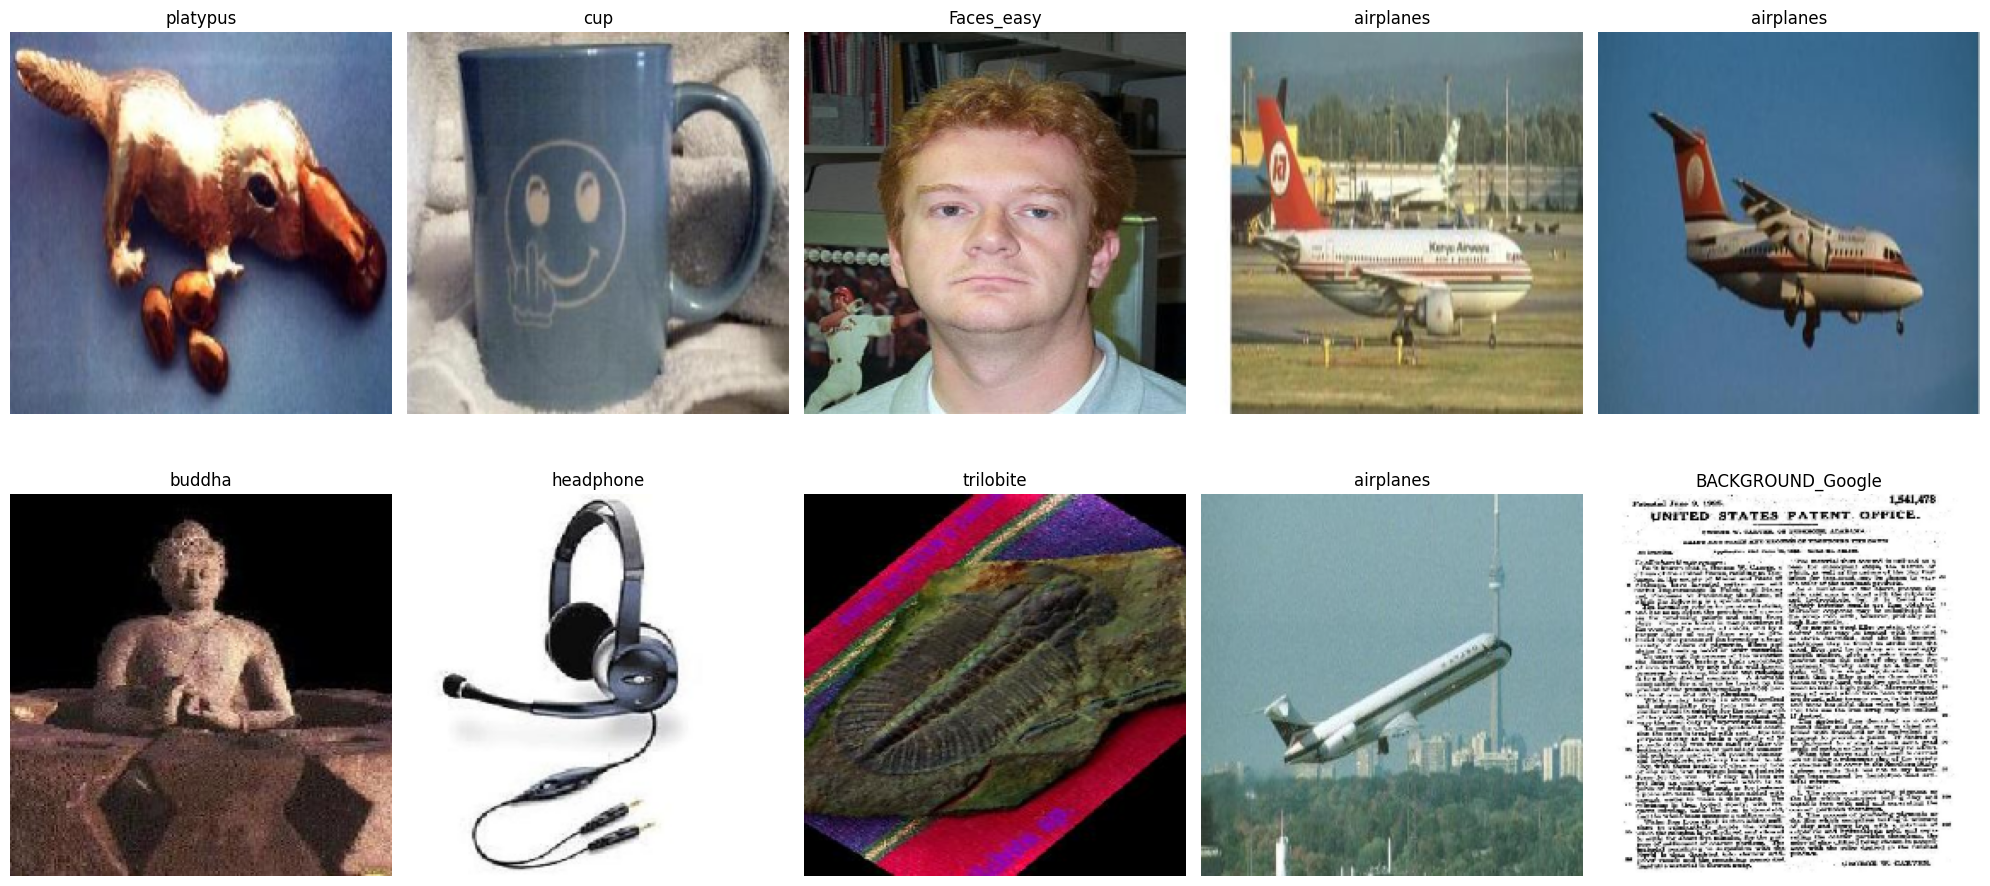

Plotting class distribution...


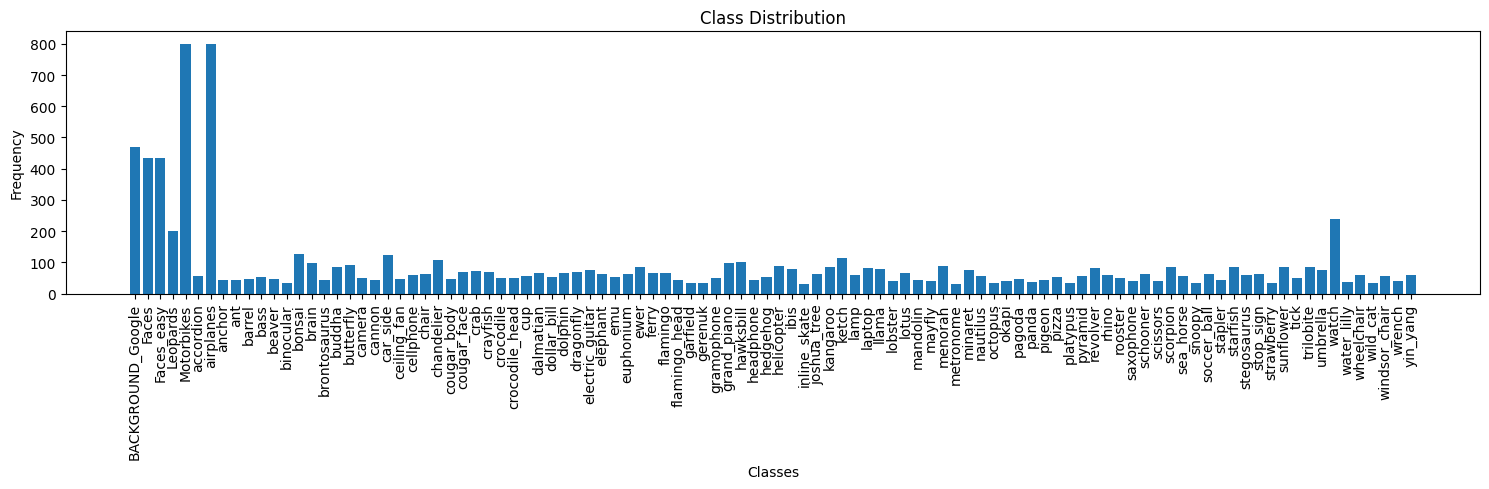


Techniques to handle class imbalance:
1. Oversampling minority classes using techniques like SMOTE
2. Undersampling majority classes
3. Class weights in model training
4. Data augmentation for minority classes
5. Mixed sampling approaches
Plotting RGB histograms...


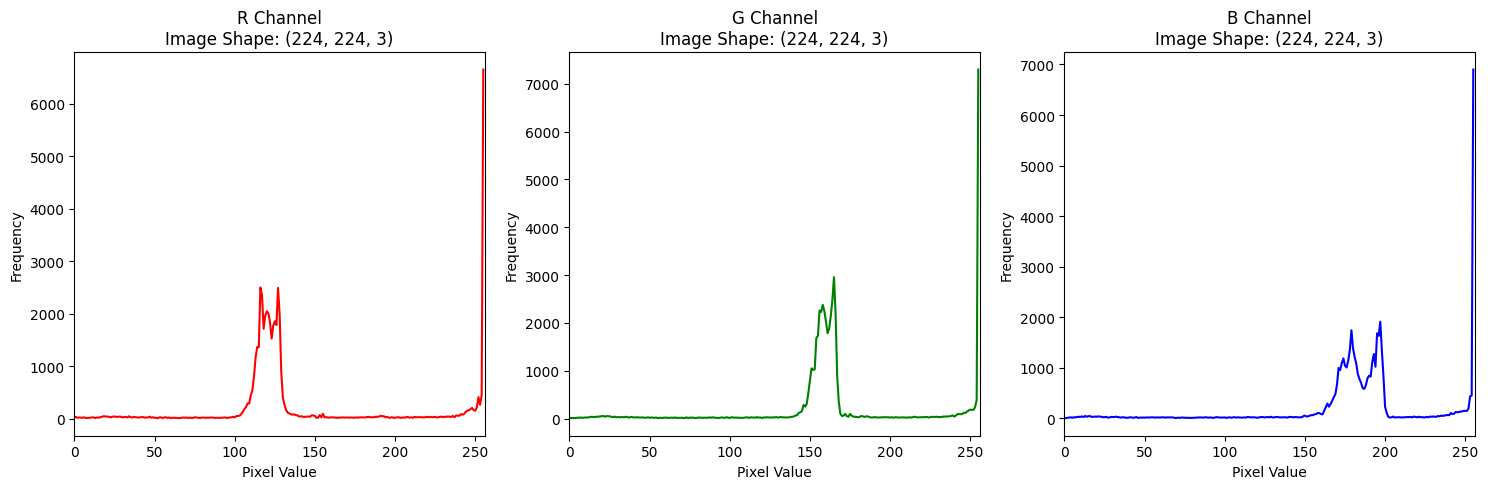

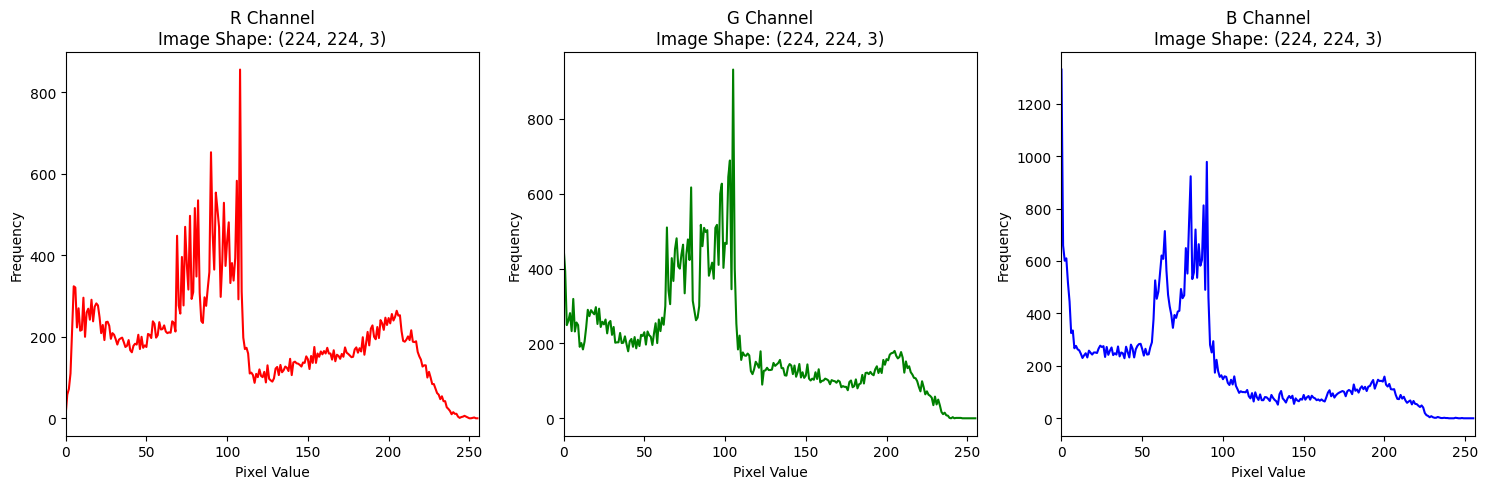

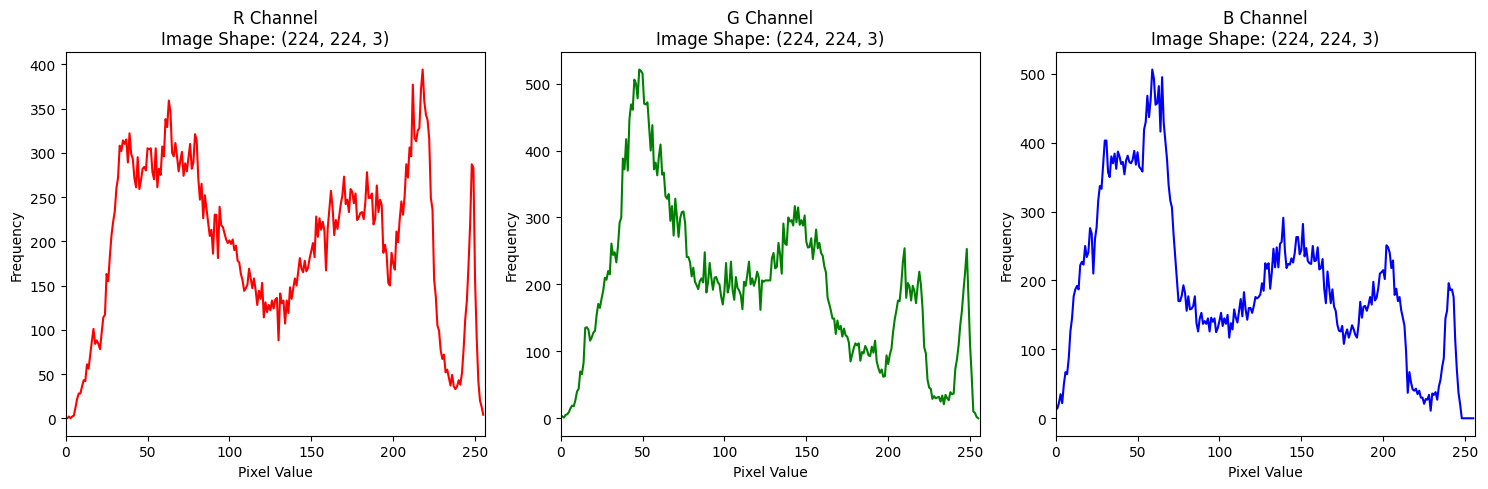

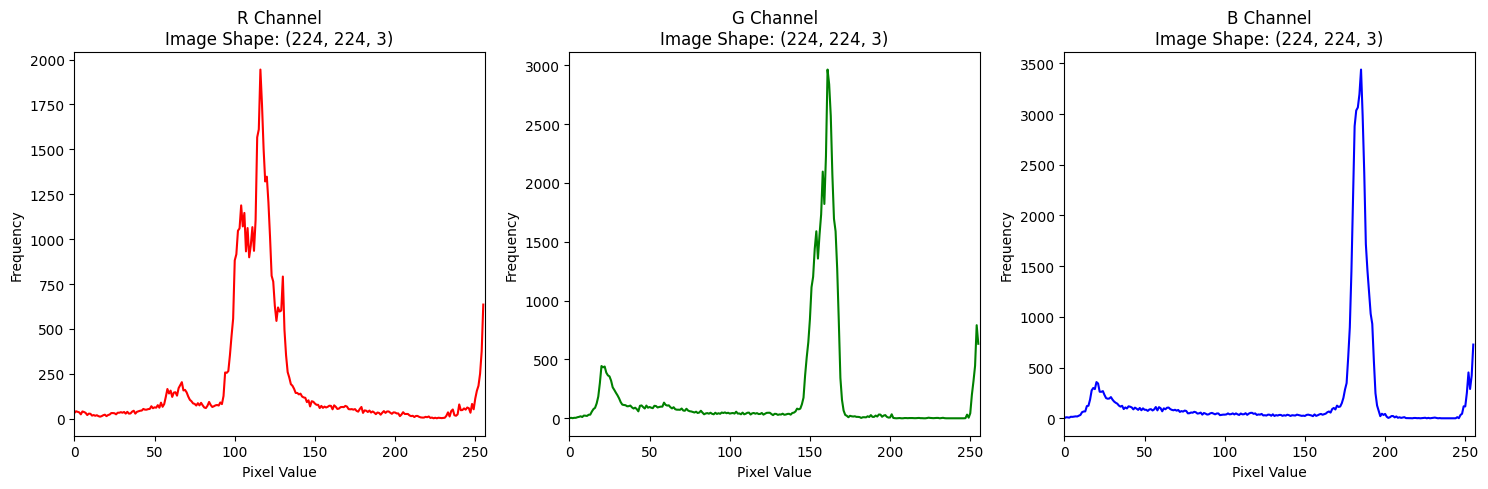

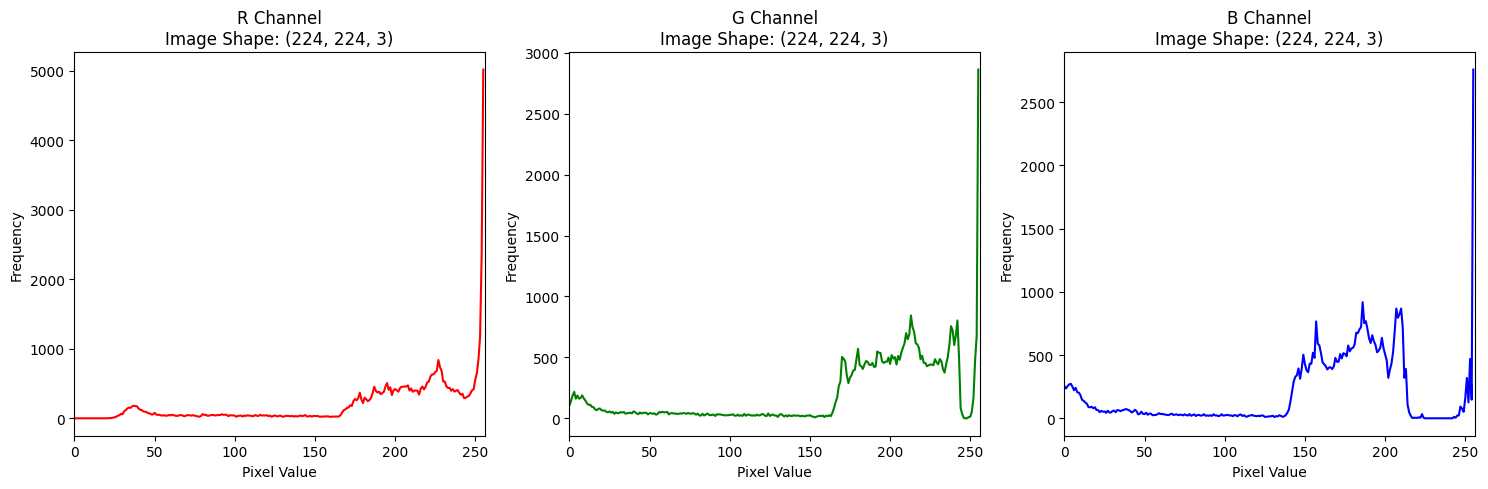

Applying geometric augmentations...


C:\Users\raksh\AppData\Roaming\Python\Python313\site-packages\albumentations\core\validation.py:45: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


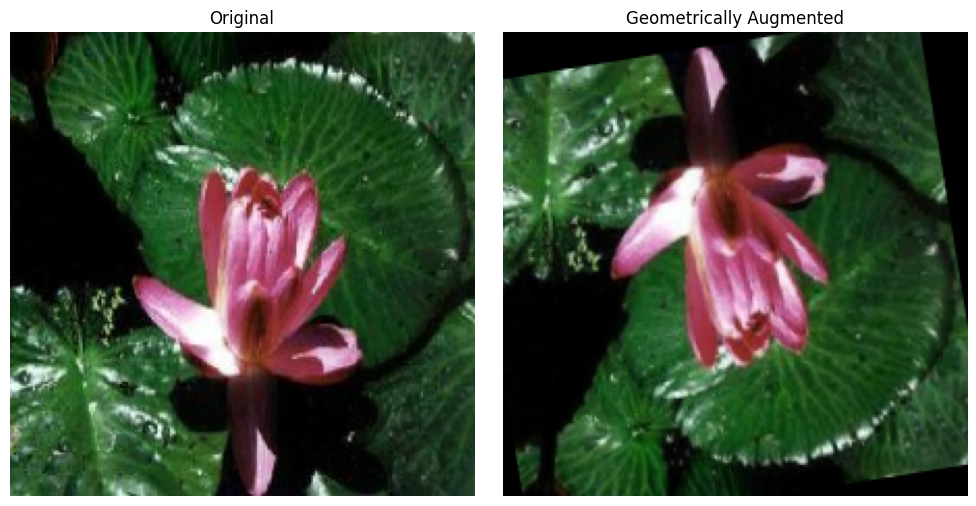

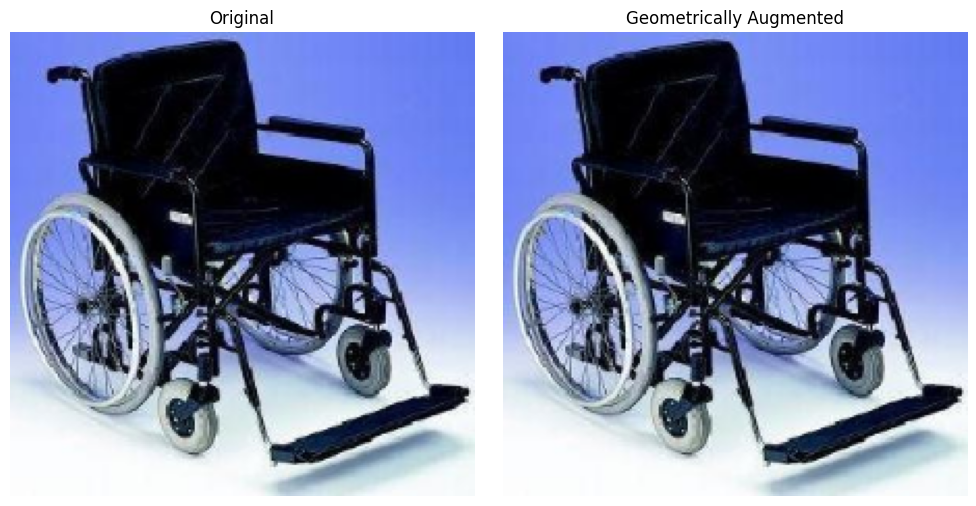

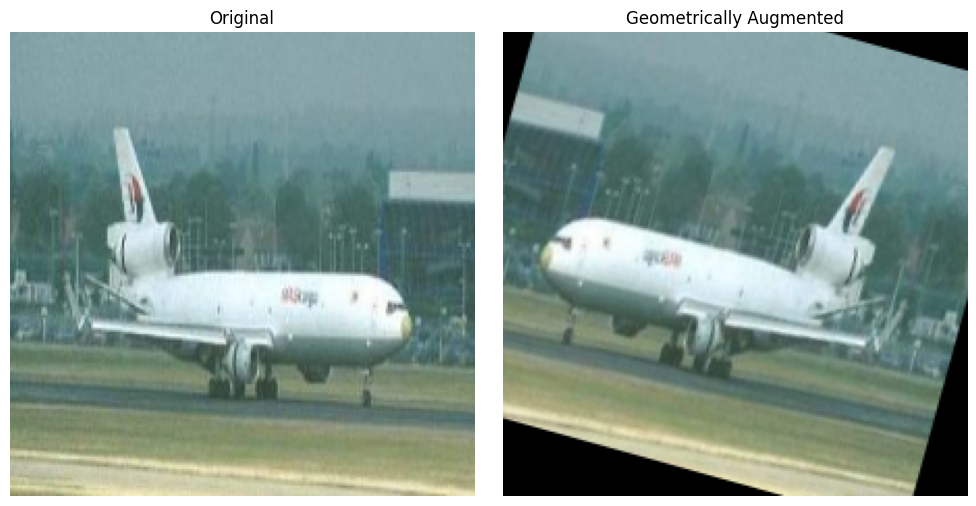

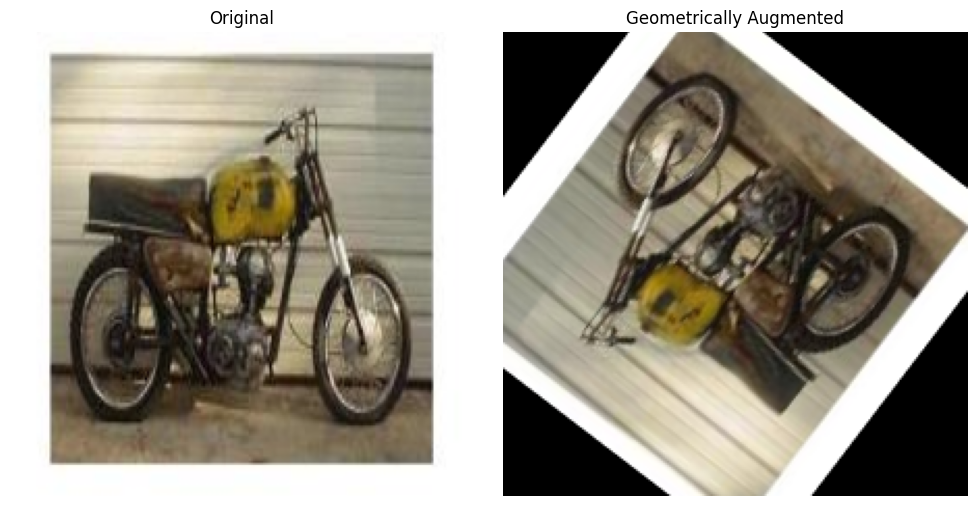

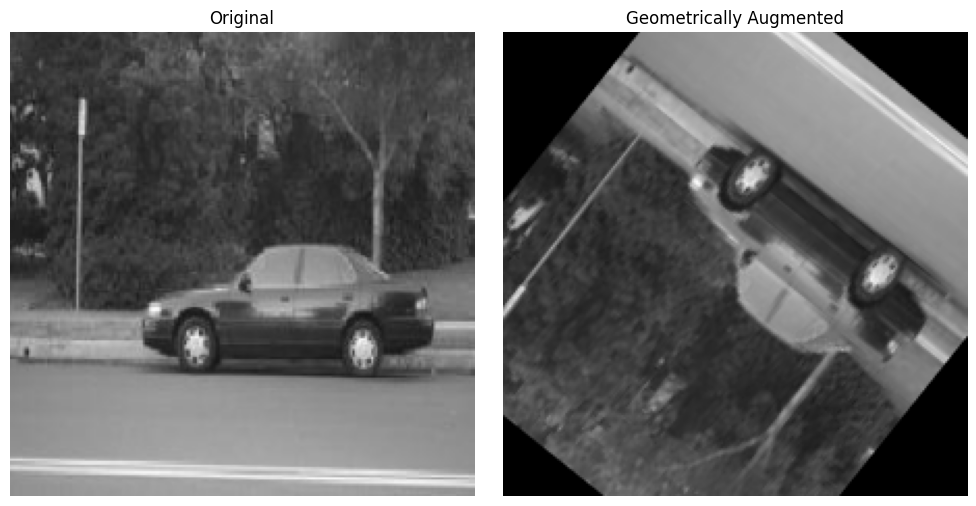

Applying color augmentations...


C:\Users\raksh\AppData\Roaming\Python\Python313\site-packages\pydantic\main.py:426: UserWarning: Pydantic serializer warnings:
  Expected `dict[str, any]` but got `UniformParams` with value `UniformParams(noise_type=...6, 0.0784313725490196)])` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


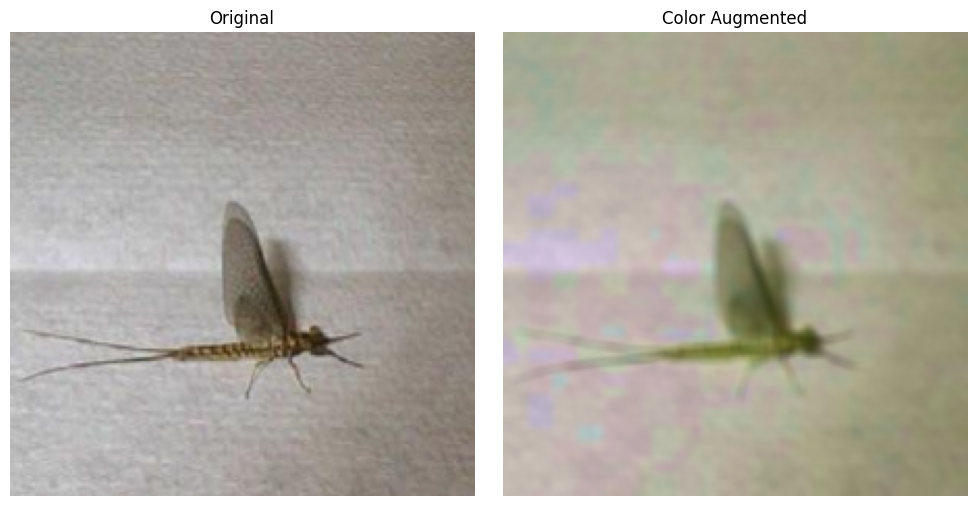

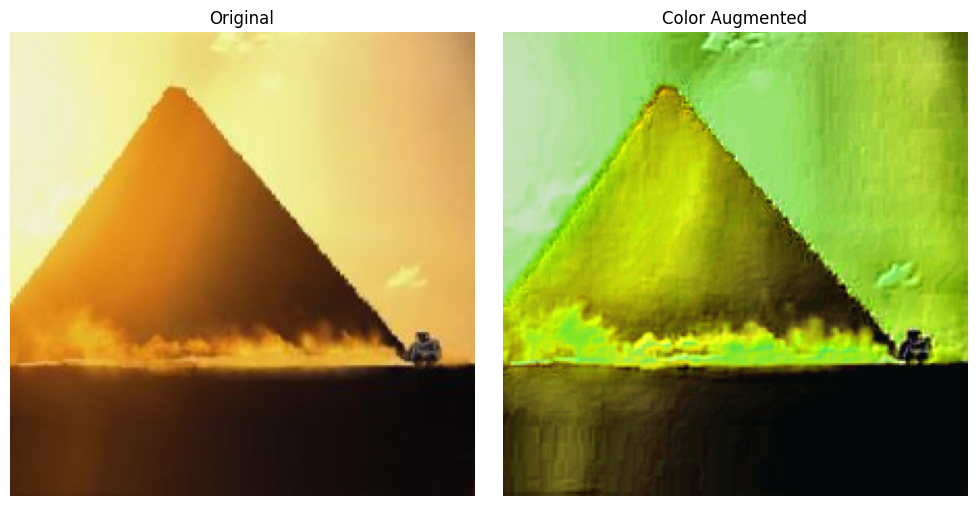

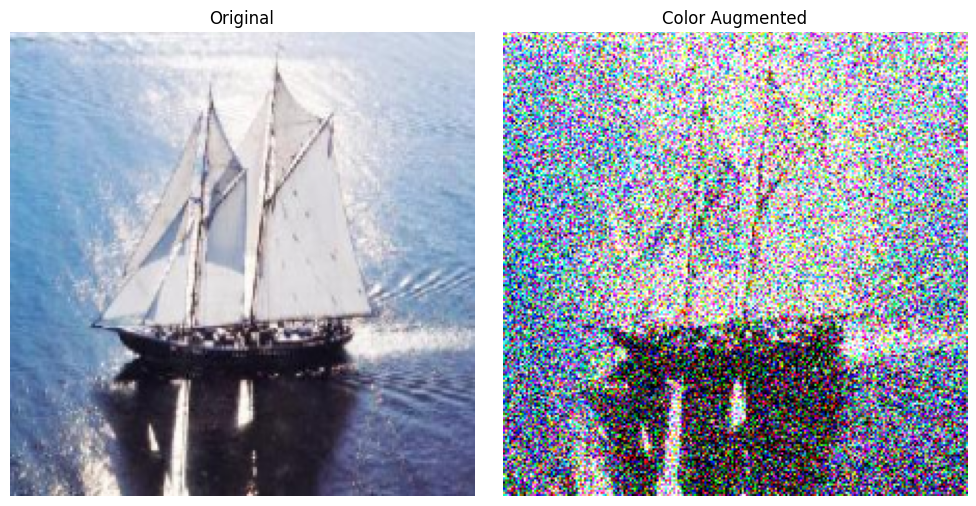

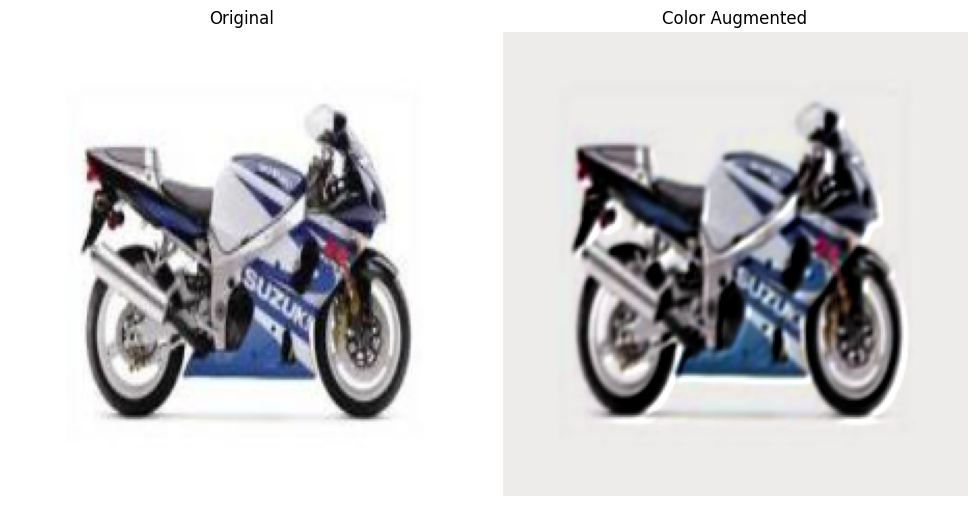

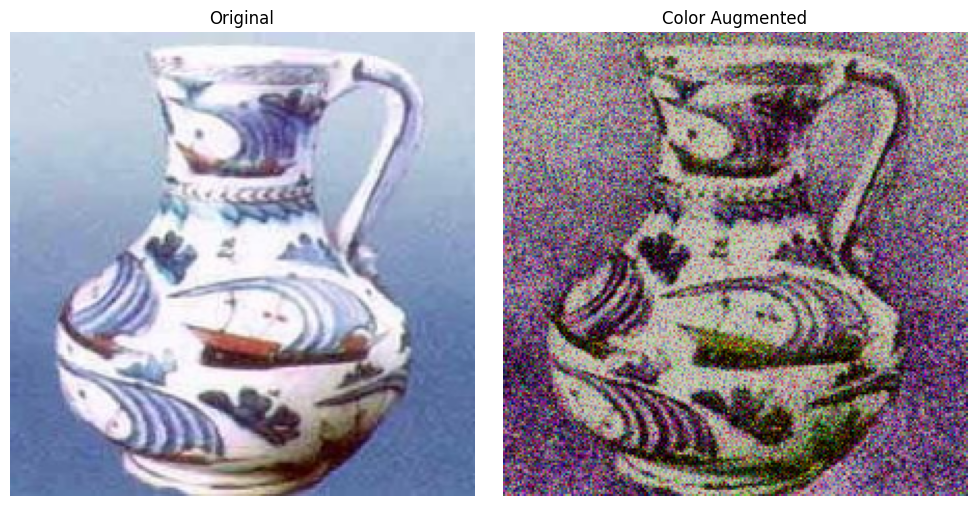

In [66]:
def main():
    # Load dataset
    print("Loading dataset...")
    images, labels, class_names = load_dataset()
    
    # Split dataset
    print("Splitting dataset...")
    X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(images, labels)
    print(f"Train set: {len(X_train)} images")
    print(f"Validation set: {len(X_val)} images")
    print(f"Test set: {len(X_test)} images")
    
    # Plot random images
    print("Plotting random images...")
    plot_random_images(images, labels, class_names)
    
    # Plot class distribution
    print("Plotting class distribution...")
    plot_class_distribution(labels, class_names)
    
    # Plot RGB histograms
    print("Plotting RGB histograms...")
    plot_rgb_histograms(X_train)
    
    # Apply geometric augmentations
    print("Applying geometric augmentations...")
    apply_geometric_augmentations(X_train)
    
    # Apply color augmentations
    print("Applying color augmentations...")
    apply_color_augmentations(X_train)

if __name__ == "__main__":
    main()